In [70]:
# Import the necessary packages
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

In [71]:
# Read in the data
def stockData(stockList):
    iteration = 0
    for stocks in stockList:
        match iteration:
            case 0:
                stockDf = pd.read_csv(
                    stocks,
                    parse_dates=["Date"],
                    infer_datetime_format=True,
                    index_col="Date",
                    dayfirst=True,
                )
                iteration = 1
                pass
            case 1:
                stockDf[stocks.split('/')[-1].split('.')[0]] = pd.read_csv(
                    stocks,
                    parse_dates=["Date"],
                    infer_datetime_format=True,
                    index_col="Date",
                    dayfirst=True,
                )["Close"]
                stockDf[stockList[0].split('/')[-1].split('.')[0]] = stockDf["Close"]
                stockDf = stockDf.loc[:, list(map(lambda x: x.split('/')[-1].split('.')[0], stockList[:2]))[:2]]
                iteration = 2
                pass
            case 2:
                stockDf[stocks.split('/')[-1].split('.')[0]] = pd.read_csv(
                    stocks,
                    parse_dates=["Date"],
                    infer_datetime_format=True,
                    index_col="Date",
                    dayfirst=True,
                )["Close"]
                pass
        pass
    if len(stockList) < 2:
        stockDf[stockList[0].split('/')[-1].split('.')[0]] = stockDf["Close"]
        return stockDf[stockList[0].split('/')[-1].split('.')[0]]
    else:
        return stockDf.dropna()


In [72]:
# Transform data to %Change returns
def pctChange(stockDf):
    for eachCol in stockDf:
        stockDf[eachCol] = stockDf[eachCol] / stockDf[eachCol].shift() - 1
        pass
    return stockDf.dropna()

In [73]:
# Define the scale data function:
def scaleData(data, portfolioProportions):
    # Scale the data
    scaledData = data.copy()
    for eachStock in scaledData:
        scaledData[eachStock] = data[eachStock] * portfolioProportions[eachStock]
        pass
    return scaledData

In [74]:
# Calculate the average return of the portfolio
def averageReturn(scaledData):
    return scaledData.sum(axis=1).mean()

In [75]:
# Calculate the risk of the portfolio
def expectedRisk(scaledData):
    return scaledData.sum(axis=1).std()

In [76]:
# Analyze the risk and return of 500 random portfolios in the stock list
def portfolioAnalysis(stockList, randomPortfolios=500):
    # Read in the data
    data = pctChange(stockData(stockList))
    # Make an empty list of empty dictionaries
    portfolioProportions = [{} for i in range(randomPortfolios)]
    averageReturns = []
    expectedRisks = []
    # Make 500 random portfolios from the stock list
    for portfolios in range(0, randomPortfolios):
        remainder = 1.0
        for eachStock in data.columns[:-1]:
            proportion = round(random.uniform(0, remainder - 0.01), 2)
            portfolioProportions[portfolios][eachStock] = proportion
            remainder = remainder - proportion
            pass
        portfolioProportions[portfolios][data.columns[-1]] = round(remainder, 2)
        pass
        # Scale the data based on the portfolio proportions
        scaledData = scaleData(data, portfolioProportions[portfolios])
        # Get average return and risk for each portfolio
        averageReturns.append(averageReturn(scaledData))
        expectedRisks.append(expectedRisk(scaledData))
        pass
    return pd.DataFrame(
        {
            "Average Return": averageReturns,
            "Expected Risk": expectedRisks,
            "Portfolio Make-up": portfolioProportions,
        }
    )

In [77]:
# Subset the portfolios near the efficient frontier
def efficientFrontier(portfolioDF):
    portfolioDF["Risk Return Ratio"] = (
        portfolioDF.loc[:, "Average Return"] / portfolioDF.loc[:, "Expected Risk"]
    )
    return portfolioDF.sort_values("Risk Return Ratio", ascending=False).head(15)

In [78]:
# Plot the risk and return of the portfolios
def plotPortfolios(portfolioDF):
    portfolioDF.plot.scatter(x = "Expected Risk", y = "Average Return", figsize = (10, 8), xlabel = "Expected Risk", ylabel = "Average Return", title = "Risk and Return of Portfolios")

In [79]:
stocks1 = ['AAPL', 'GOOG']

In [80]:
stocks2 = ['GOOG', 'AAPL']

In [81]:
files1 = []
for path in stocks1:
    x = !find . -name {path}.csv | head -1
    files1.append(x[0])

In [82]:
files2 = []
for path in stocks2:
    x = !find . -name {path}.csv | head -1
    files2.append(x[0])

In [86]:
file1DF = portfolioAnalysis(files1)
file1DF.loc[file1DF.loc[:, 'Portfolio Make-up'].apply(lambda x: x['AAPL']) == .95,:]
#file1DF = stockData(files1)
#file1DF.head()


,Average Return,Expected Risk,Portfolio Make-up
100,0.001449,0.020396,"{'AAPL': 0.95, 'GOOG': 0.05}"
309,0.001449,0.020396,"{'AAPL': 0.95, 'GOOG': 0.05}"
343,0.001449,0.020396,"{'AAPL': 0.95, 'GOOG': 0.05}"
429,0.001449,0.020396,"{'AAPL': 0.95, 'GOOG': 0.05}"


In [87]:
file2DF = portfolioAnalysis(files2)
file2DF.loc[file2DF.loc[:, 'Portfolio Make-up'].apply(lambda x: x['AAPL']) == .95,:]
#file2DF = stockData(files2)
#file2DF.head()

,Average Return,Expected Risk,Portfolio Make-up
2,0.001449,0.020396,"{'GOOG': 0.05, 'AAPL': 0.95}"
41,0.001449,0.020396,"{'GOOG': 0.05, 'AAPL': 0.95}"
88,0.001449,0.020396,"{'GOOG': 0.05, 'AAPL': 0.95}"
290,0.001449,0.020396,"{'GOOG': 0.05, 'AAPL': 0.95}"
344,0.001449,0.020396,"{'GOOG': 0.05, 'AAPL': 0.95}"


In [88]:
efficientFrontier(file1DF)

,Average Return,Expected Risk,Portfolio Make-up,Risk Return Ratio
259,0.001336,0.018298,"{'AAPL': 0.7, 'GOOG': 0.3}",0.072987
171,0.001336,0.018298,"{'AAPL': 0.7, 'GOOG': 0.3}",0.072987
269,0.001336,0.018298,"{'AAPL': 0.7, 'GOOG': 0.3}",0.072987
243,0.001340,0.018361,"{'AAPL': 0.71, 'GOOG': 0.29}",0.072984
189,0.001340,0.018361,"{'AAPL': 0.71, 'GOOG': 0.29}",0.072984
288,0.001340,0.018361,"{'AAPL': 0.71, 'GOOG': 0.29}",0.072984
174,0.001340,0.018361,"{'AAPL': 0.71, 'GOOG': 0.29}",0.072984
344,0.001340,0.018361,"{'AAPL': 0.71, 'GOOG': 0.29}",0.072984
197,0.001331,0.018237,"{'AAPL': 0.69, 'GOOG': 0.31}",0.072982
33,0.001331,0.018237,"{'AAPL': 0.69, 'GOOG': 0.31}",0.072982


In [89]:
efficientFrontier(file2DF)

,Average Return,Expected Risk,Portfolio Make-up,Risk Return Ratio
17,0.001336,0.018298,"{'GOOG': 0.3, 'AAPL': 0.7}",0.072987
252,0.001336,0.018298,"{'GOOG': 0.3, 'AAPL': 0.7}",0.072987
349,0.001336,0.018298,"{'GOOG': 0.3, 'AAPL': 0.7}",0.072987
103,0.001340,0.018361,"{'GOOG': 0.29, 'AAPL': 0.71}",0.072984
261,0.001340,0.018361,"{'GOOG': 0.29, 'AAPL': 0.71}",0.072984
160,0.001340,0.018361,"{'GOOG': 0.29, 'AAPL': 0.71}",0.072984
368,0.001340,0.018361,"{'GOOG': 0.29, 'AAPL': 0.71}",0.072984
71,0.001340,0.018361,"{'GOOG': 0.29, 'AAPL': 0.71}",0.072984
448,0.001340,0.018361,"{'GOOG': 0.29, 'AAPL': 0.71}",0.072984
182,0.001331,0.018237,"{'GOOG': 0.31, 'AAPL': 0.69}",0.072982


/home/codespace/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


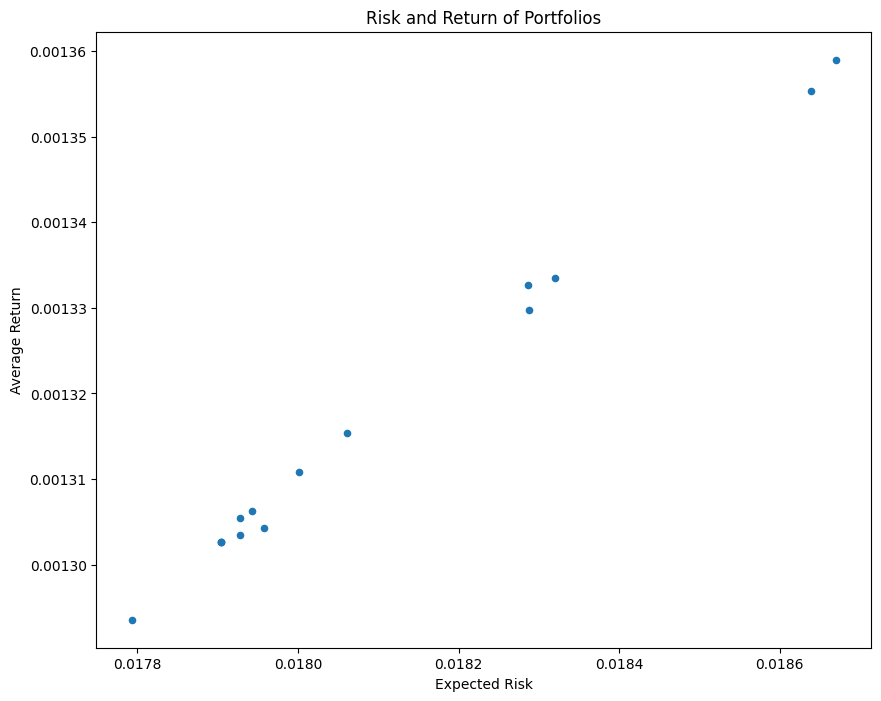

In [85]:
plotPortfolios(efficientFrontier(portfolioAnalysis(files)))